# Extract deep coadds

 work with Weakly_2022_44
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/22
- update : 2023/12/22


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_44/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_44/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_44/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+d053631def 	current w_2023_44 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.daf.base as dafBase

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch
# Astropy
from astropy.visualization import ZScaleInterval, AsinhStretch

import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import pprint

In [6]:
#Set the matplotlib plot color table.
plt.style.use('tableau-colorblind10')

In [7]:
# Let us also set `lsst.afw.display` to use the `matplotlib` backend:
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [8]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

## Give the collection

In [9]:
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"

## Config

## deepCoadd

In [10]:
datasetRefs = registry.queryDatasets(datasetType='deepCoadd', collections=my_collection, where= "instrument='LATISS'")

In [11]:
all_dataId = []
all_deepcoadds  = []
all_titles = []

for i, ref in enumerate(datasetRefs):
   
    print(f"========({i})================datasetType = deepCoadd ============================================")
    print("fullId..................:",ref.dataId.full)
    print("band....................:",ref.dataId["band"])
    print("skymap..................:",ref.dataId["skymap"])
    print("tract..................:",ref.dataId["tract"])
    print("patch..................:",ref.dataId["patch"])
    print("run.....................:",ref.run)
    band = ref.dataId["band"]
    tract = ref.dataId["tract"]
    patch = ref.dataId["patch"]

    the_dataId = {'band': band, 'tract': tract, 'patch': patch}
    the_title = f"Auxtel deepCoadd : band={band}, tract={tract}, patch={patch}" 
    my_deepCoadd = butler.get('deepCoadd', dataId=ref.dataId.full,collections=my_collection)
    
    all_dataId.append(the_dataId) 
    all_deepcoadds.append(my_deepCoadd)
    all_titles.append(the_title)
    
    if i > 10:
        break

========(0)================datasetType = deepCoadd ============================================
fullId..................: {band: 'i', skymap: 'latiss_v1', tract: 452, patch: 42}
band....................: i
skymap..................: latiss_v1
tract..................: 452
patch..................: 42
run.....................: LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553/20231120T163323Z
========(1)================datasetType = deepCoadd ============================================
fullId..................: {band: 'r', skymap: 'latiss_v1', tract: 3863, patch: 243}
band....................: r
skymap..................: latiss_v1
tract..................: 3863
patch..................: 243
run.....................: LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553/20231120T163323Z
========(2)================datasetType = deepCoadd ============================================
fullId..................: {band: 'r', skym

# Select the index

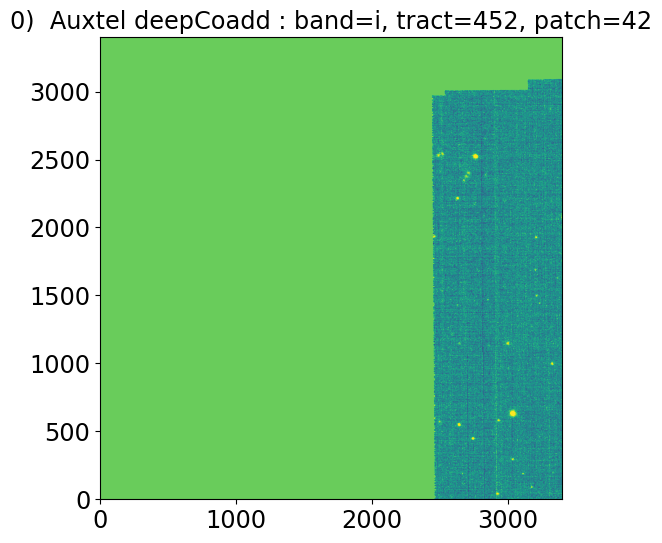

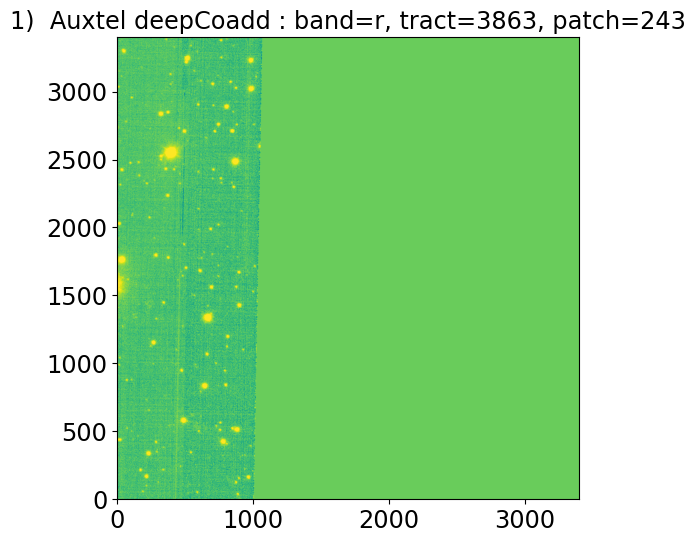

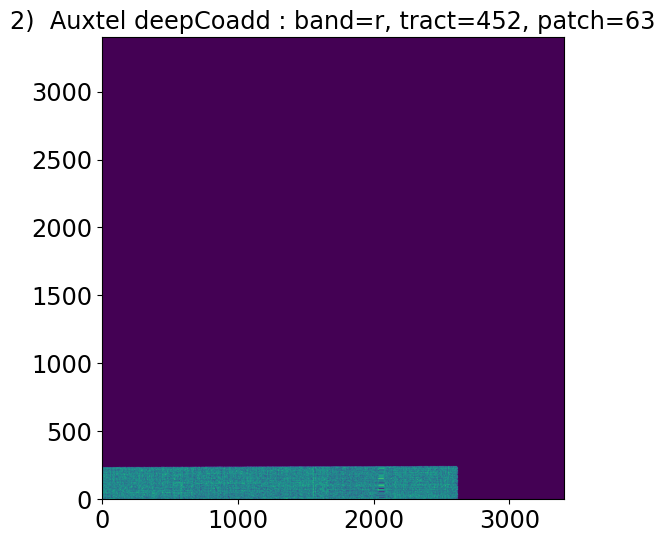

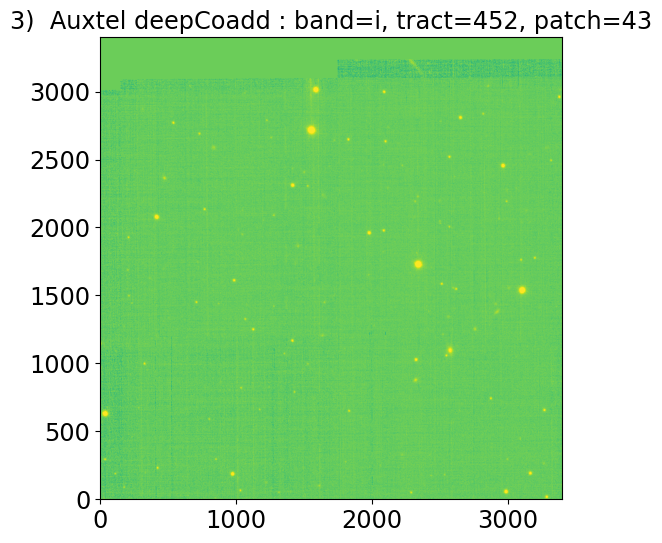

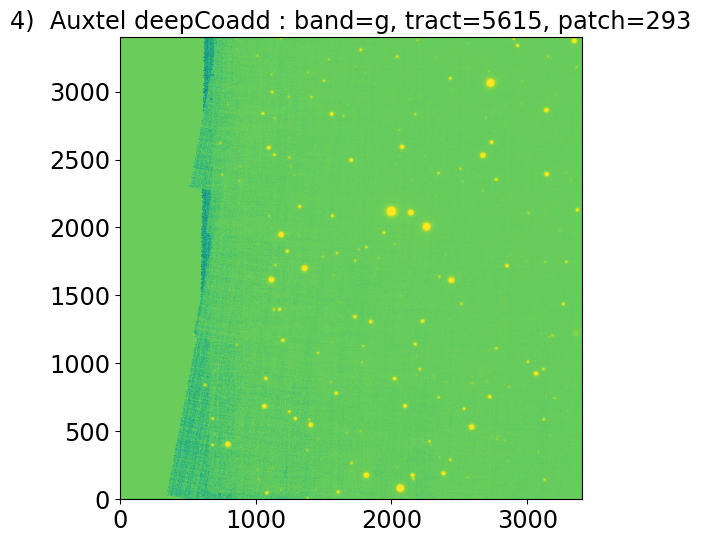

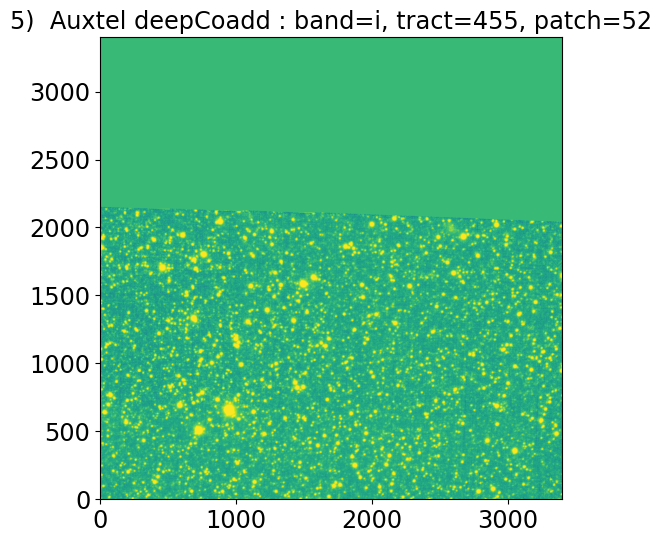

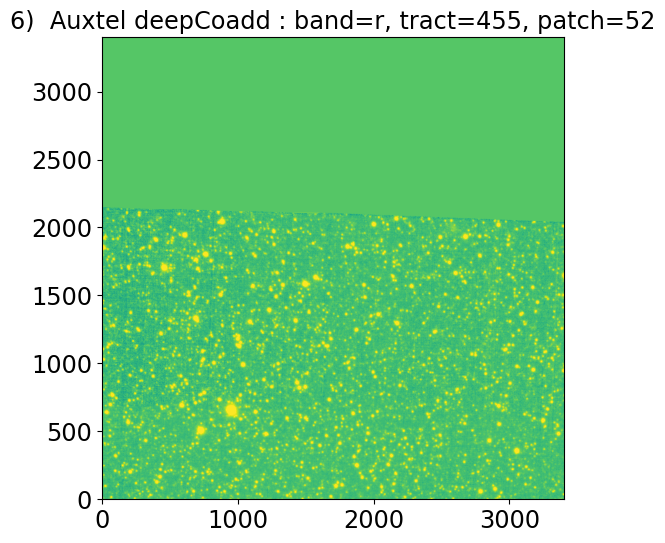

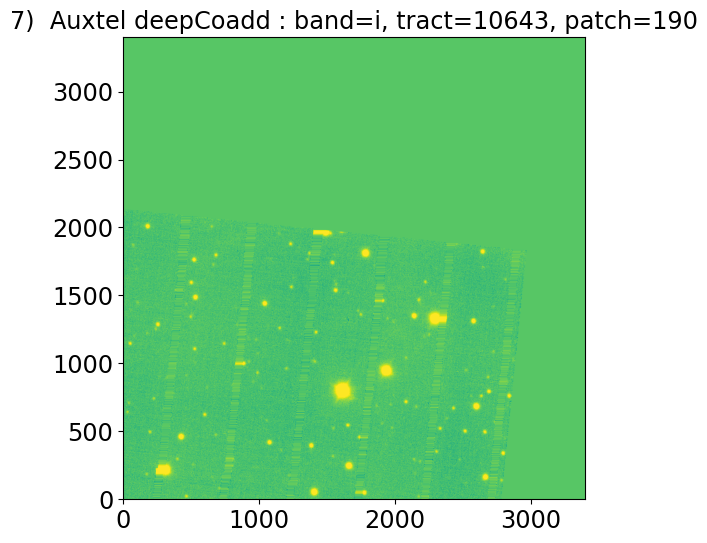

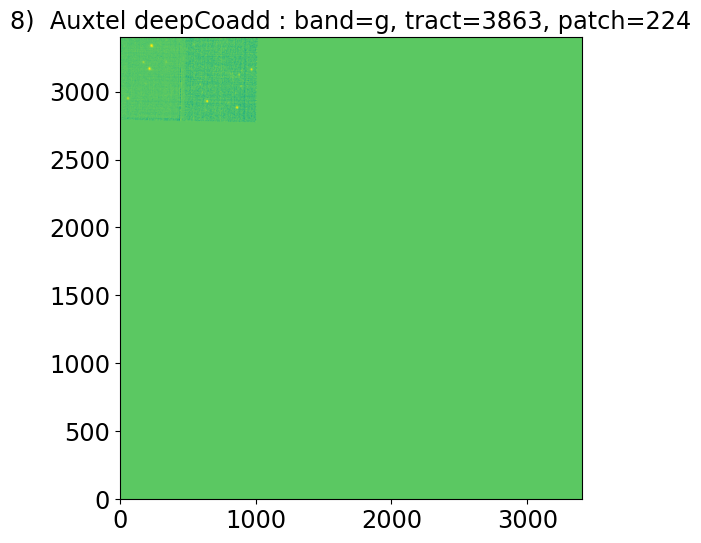

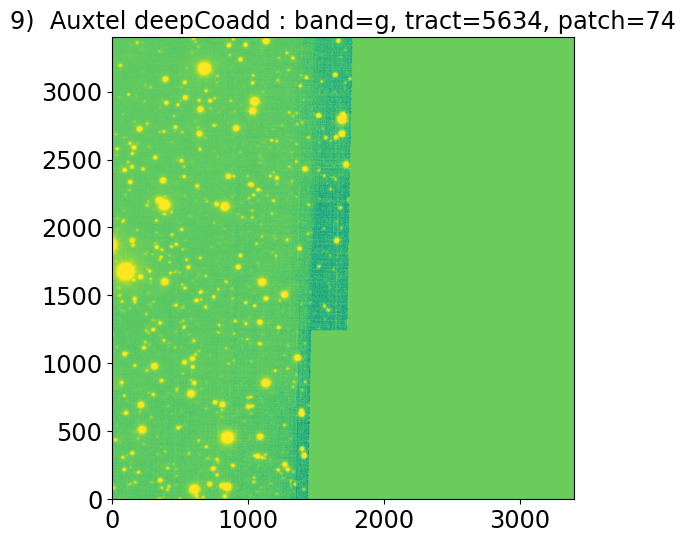

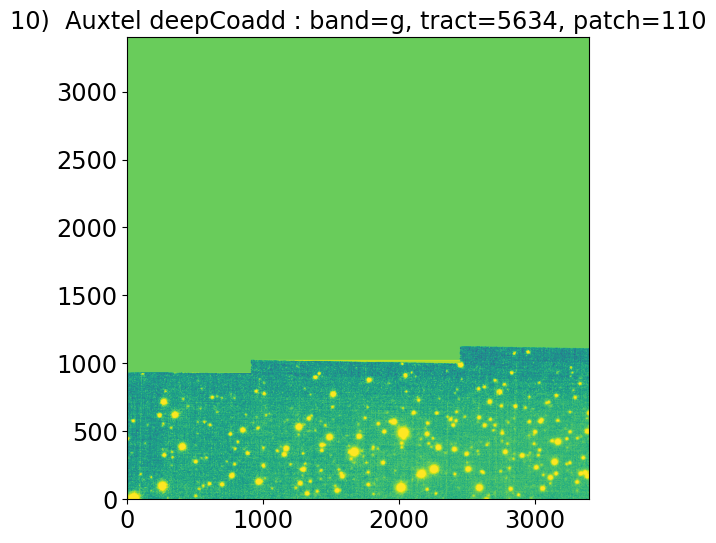

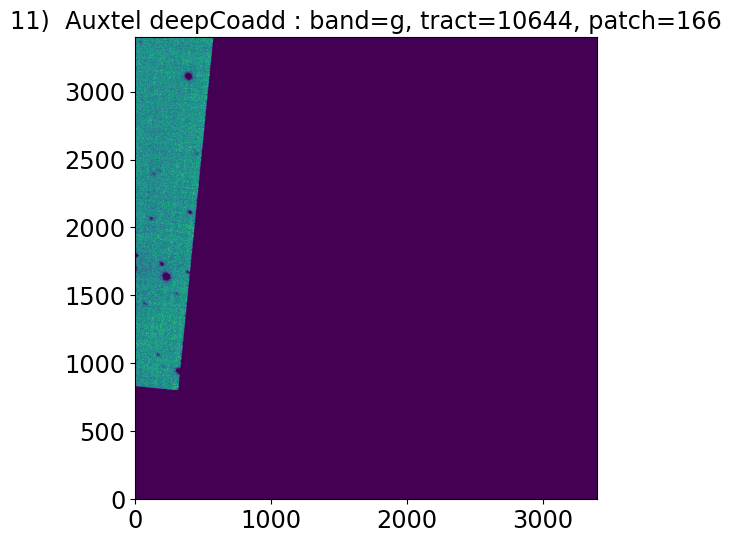

In [12]:
N = len(all_deepcoadds)

for index in range(N):
    the_dataid = all_dataId[index]
    the_deepcoadd = all_deepcoadds[index]
    the_title = f"{index})  "+all_titles[index]

    # Plot the calexp we just retrieved
    plt.figure()
    #afw_display = afwDisplay.Display()
    #afw_display.scale('asinh', 'zscale')
    #afw_display.mtv(the_deepcoadd.image,title=the_title )
    #plt.gca().axis('on')
    transform = AsinhStretch() + ZScaleInterval()
    scaledImage = transform(the_deepcoadd.image.array)
    #scaledImage = np.flipud(scaledImage)
    plt.imshow(scaledImage,origin="lower")
    plt.title(the_title)
    plt.show()

    
    